In [ ]:
import numpy as np
import tensorly as tl
import os
from tensorly.decomposition import tucker, parafac, non_negative_tucker
from tensorly import tucker_to_tensor
from matplotlib import pyplot as plt
from sklearn.utils.extmath import randomized_svd
import time
import multiprocessing as mp
import skvideo.io
import apgpy
from scipy.sparse.linalg import svds

from util import std_logistic_function, get_square_set, square_unfolding, normalized_error, tenips_general
np.random.seed(1)

# preprocess video data

In [ ]:
video_X = vread("walking_past_camera.mp4")
video_X_trunc = video_X[100:-193, :, :, :]
video_grey = skvideo.utils.rgb2gray(video_X_trunc)
video_grey = video_grey[:, :, :, 0]

In [ ]:
# synthetic parameter tensor
video_A = (video_grey - 128)/64
# synthetic propensity tensor
video_prop = std_logistic_function(video_A)

In [ ]:
def get_B_obs_proportional(prop, B):
    """
    Get the mask tensor from entrywise sampling.
    
    Args:
    prop (np.ndarray): the propensity tensor.
    B (np.ndarray):    the data tensor.
    
    Return:
    sample_prob_X (np.ndarray): an entrywise Uniform[0, 1] random tensor.
    mask_X (np.ndarray):        the mask tensor.
    """
    sample_prob_X = np.random.uniform(0, 1, B.shape)
    mask_X = (np.zeros(B.shape)) 
    mask_X[sample_prob_X <= prop] = True
    return sample_prob_X, mask_X

In [ ]:
sample_prob_X, mask_X = get_B_obs_proportional(video_prop, video_grey)

propensity recovery

In [ ]:
def one_bit_MC_fully_observed(M, link, tau, gamma, max_rank=None, init='zero',
                              apg_max_iter=500, apg_eps=1e-12, fixed_step_size=False,
                              apg_use_restart=True):
    """
    Algorithm 1, the prox-prox.
    
    Args:
    M: the mask tensor.
    link: the link function.
    tau: as in Algorithm 1.
    gamma: as in Algorithm 1.
    max_rank: the fixed rank for prox-prox.
    init: initialization method.
    ...(apgpy parameters)...
    
    Returns:
    A_sq_pred: the predicted parameter tensor.    
    """
    m = M.shape[0]
    n = M.shape[1]
    tau_sqrt_mn = tau * np.sqrt(m*n)

    def prox(_A, t):
        _A = _A.reshape(m, n)

        if max_rank is None:
            U, S, VT = np.linalg.svd(_A, full_matrices=False)
        else:
            U, S, VT = randomized_svd(_A, max_rank)
            
        # first prox
        nuclear_norm = np.sum(S)
        if nuclear_norm > tau_sqrt_mn:
            S *= tau_sqrt_mn / nuclear_norm
            _A = np.dot(U * S, VT)

        # second prox
        mask = np.abs(_A) > gamma
        if mask.sum() > 0:
            _A[mask] = np.sign(_A[mask]) * gamma

        return _A.flatten()

    def grad(_A):
        return link(_A) - M
    
    if init == 'zero':
        A_init = np.zeros(m*n)
    elif init == 'uniform':
        A_init = np.random.rand(m*n)
    
    print(fixed_step_size)
    A_hat = apgpy.solve(grad, prox, A_init,
                        max_iters=apg_max_iter,
                        eps=apg_eps,
                        use_gra=True,
                        use_restart=apg_use_restart,
                        fixed_step_size=fixed_step_size,
                        quiet=True)
    
    A_sq_pred = A_hat.reshape(m, n)
    return A_sq_pred

In [ ]:
prop_X_sq = square_unfolding(video_prop) # square unfolding of the propensity tensor
mask_X_sq = square_unfolding(mask_X) # square unfolding of the mask tensor

In [ ]:
A_sq = square_unfolding(video_A) # square unfolding of the parameter tensor
_, A_Sigma, _ = randomized_svd(A_sq, n_components=50, n_iter=20, random_state=None)
alpha_of_A_sq = np.max(np.abs(A_sq)) # true alpha of A_sq
theta_of_A_sq = np.sum(A_Sigma) / (np.sqrt(np.prod(A_sq.shape))) # true theta of A_sq

In [ ]:
def evaluate_sq(max_iter, fixed_step_size=False):
    """
    Evaluate Algorithm 1.
    """
    
    print("maximum iteration: {}".format(max_iter))
    
    prop_X_sq = square_unfolding(video_prop)
    mask_X_sq = square_unfolding(mask_X)

    start = time.time()
    A_sq_pred = one_bit_MC_fully_observed(mask_X_sq, std_logistic_function, grad_std_logistic_function, 
                                          apg_max_iter=max_iter, tau=5 * theta_of_A_sq, gamma=5 * alpha_of_A_sq, 
                                          max_rank=50, init='uniform', fixed_step_size=fixed_step_size)
    elapsed = time.time() - start
    print("maximum iteration {} finished".format(max_iter))
    return deepcopy(max_iter), deepcopy(elapsed), deepcopy(A_sq_pred)

In [ ]:
result = evaluate_sq(2, True)

# predicted propensity tensor
video_prop_pred = tl.fold(std_logistic_function(result[2]), mode=0, shape=video_grey.shape)

In [26]:
# relative error of the predicted propensity tensor
normalized_error(tl.unfold(video_prop, mode=0), std_logistic_function(result[2]))

0.15199311968526427

In [ ]:
sample_X = np.multiply(video_grey, mask_X) # B_obs
r = [50, 50, 50] # target rank

# predicted tensor from TenIPS on predicted propensities
X_res_pred = tenips_general(sample_X, video_prop_pred, r) 

In [35]:
normalized_error(video_grey, X_res_pred)

0.28533443841337064

In [ ]:
# pixel value clipping
adjusted_X_res_pred = X_res_pred.copy()
adjusted_X_res_pred[adjusted_X_res_pred>255] = 255.
adjusted_X_res_pred[adjusted_X_res_pred<0] = 0.

Figure 5d, the recovered frame with Algorithm 1 and predicted propensities

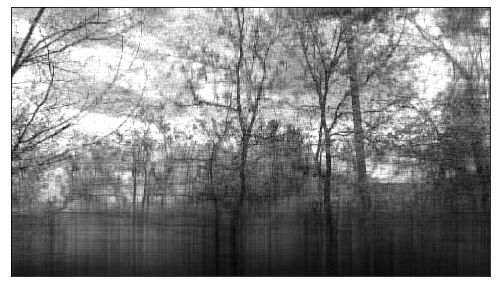

In [39]:
fontsize = 18
frame_idx = 500
# title= "recovered by ips with rank {}: frame {}".format(rank_video, frame_idx)
frame = adjusted_X_res_pred[frame_idx,:,:]
plt.figure(figsize=(7,10))
plt.imshow(frame, cmap = 'gray')
plt.yticks([], fontsize = fontsize)
plt.xticks([], fontsize = fontsize)
# plt.title(title, fontsize = fontsize)
plt.tight_layout()

Figure 5a, the original frame

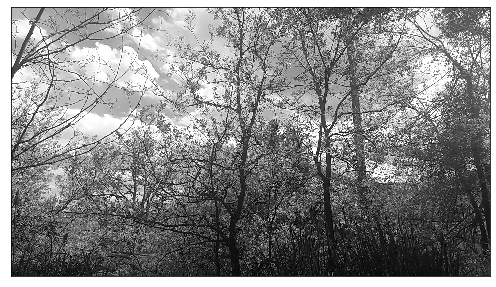

In [28]:
fontsize = 18
frame_idx = 500
title= "original: frame {}".format(frame_idx)
frame = video_grey[frame_idx,:,:]
plt.figure(figsize=(7,10))
plt.imshow(frame, cmap = 'gray')
plt.yticks([], fontsize = fontsize)
plt.xticks([], fontsize = fontsize)
# plt.title(title, fontsize = fontsize)
plt.tight_layout()

In [ ]:
# compute the cases in 5b and 5c

rank_video = [50, 50, 50]

ips_recovered_video = tenips_general(sample_X,video_prop)

prop_input = np.ones(video_grey.shape)
reweighted_naive_recovered_video = tenips_general(sample_X,prop_input) / video_prop

reweighted_naive_recovered_video[reweighted_naive_recovered_video>255] = 255.
reweighted_naive_recovered_video[reweighted_naive_recovered_video<0] = 0.
adjusted_ips_recovered_video = ips_recovered_video.copy()
adjusted_ips_recovered_video[adjusted_ips_recovered_video>255] = 255.
adjusted_ips_recovered_video[adjusted_ips_recovered_video<0] = 0.

Figure 5c, the frame from TenIPS on true propensities

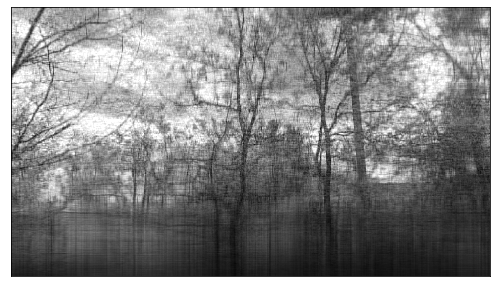

In [30]:
fontsize = 18
frame_idx = 500
title= "recovered by ips with rank {}: frame {}".format(rank_video, frame_idx)
frame = adjusted_ips_recovered_video[frame_idx,:,:]
plt.figure(figsize=(7,10))
plt.imshow(frame, cmap = 'gray')
plt.yticks([], fontsize = fontsize)
plt.xticks([], fontsize = fontsize)
# plt.title(title, fontsize = fontsize)
plt.tight_layout()

Figure 5b, TenIPS with MCAR assumption on MNAR data

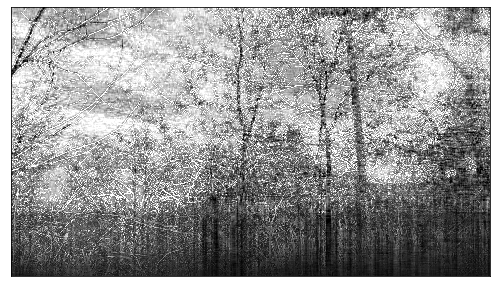

In [31]:
fontsize = 18
frame_idx = 500
title= "recovered by naive with rank {}: frame {}".format(rank_video, frame_idx)
frame = reweighted_naive_recovered_video[frame_idx,:,:]
plt.figure(figsize=(7,10))
plt.imshow(frame, cmap = 'gray')
plt.yticks([], fontsize = fontsize)
plt.xticks([], fontsize = fontsize)
plt.tight_layout()